In [ ]:
from torchvision.datasets import MNIST
import torch
import numpy as np

In [ ]:
train = MNIST(root='data', train=True, download=True)
test = MNIST(root='data', train=False, download=True)

In [ ]:
class ClassWiseColor(torch.nn.Module):
    def __init__(self, num_classes):
        super(ClassWiseColor, self).__init__()
        self.num_classes = num_classes
        self.colors = [[0,0],[1,1],[2,2],[1,1],[2,2],[0,0],[1,1],[2,2],[2,2],[0,0]]
        self.test_colors = [[0,1],[1,2],[2,0],[1,2],[2,0],[0,1],[1,2],[2,0],[0,1],[0,1]]
        
    def forward(self, img,label,train=True):
        colored_img = img.copy()
        colored_img = np.array(colored_img)
        colored_img = np.repeat(colored_img[:, :, np.newaxis], 3, axis=2)
        random_label = np.random.randint(0,self.num_classes)
        for channel in range(colored_img.shape[-1]):
            if train:
                if channel in self.colors[random_label]:
                    colored_img[:,:,channel][colored_img[:,:,channel]>10] = 255
                else:
                    colored_img[:,:,channel][colored_img[:,:,channel]>10] = 0
            else:
                if channel in self.test_colors[random_label]:
                    colored_img[:,:,channel][colored_img[:,:,channel]>10] = 255
                else:
                    colored_img[:,:,channel][colored_img[:,:,channel]>10] = 0

        return colored_img,label

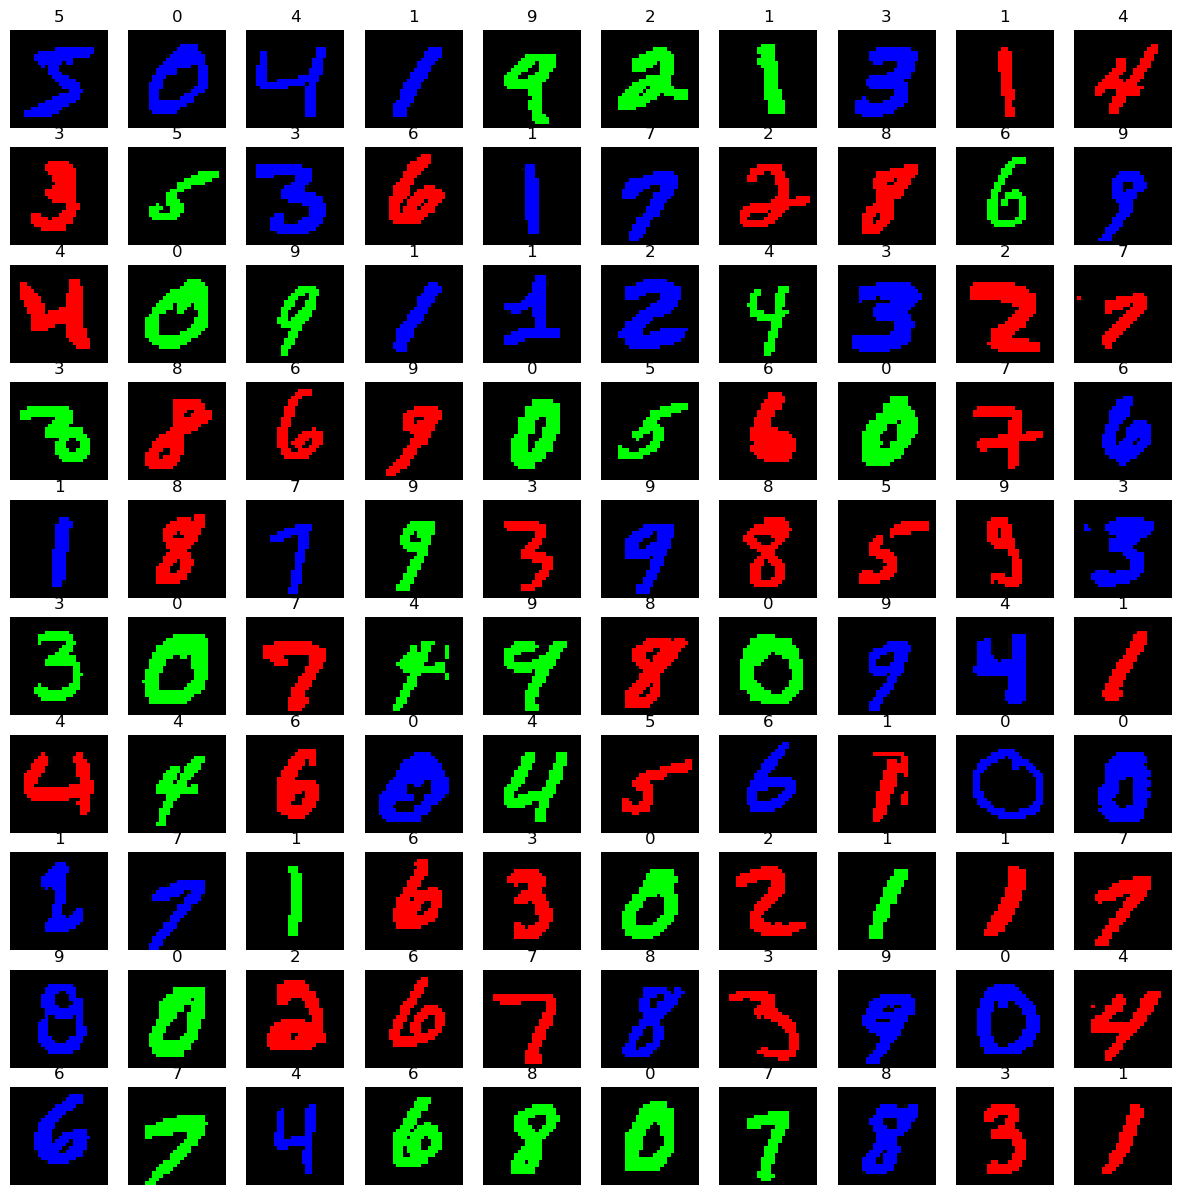

In [ ]:
import matplotlib.pyplot as plt
color = ClassWiseColor(10)
fig,ax = plt.subplots(10,10,figsize=(15,15))
for i in range(10):
    for j in range(10):
        img, label = train[j+10*i]
        colored_img, label = color(img, label)
        ax[i][j].imshow(colored_img)
        ax[i][j].set_title(label)
        ax[i][j].axis('off')
plt.show()

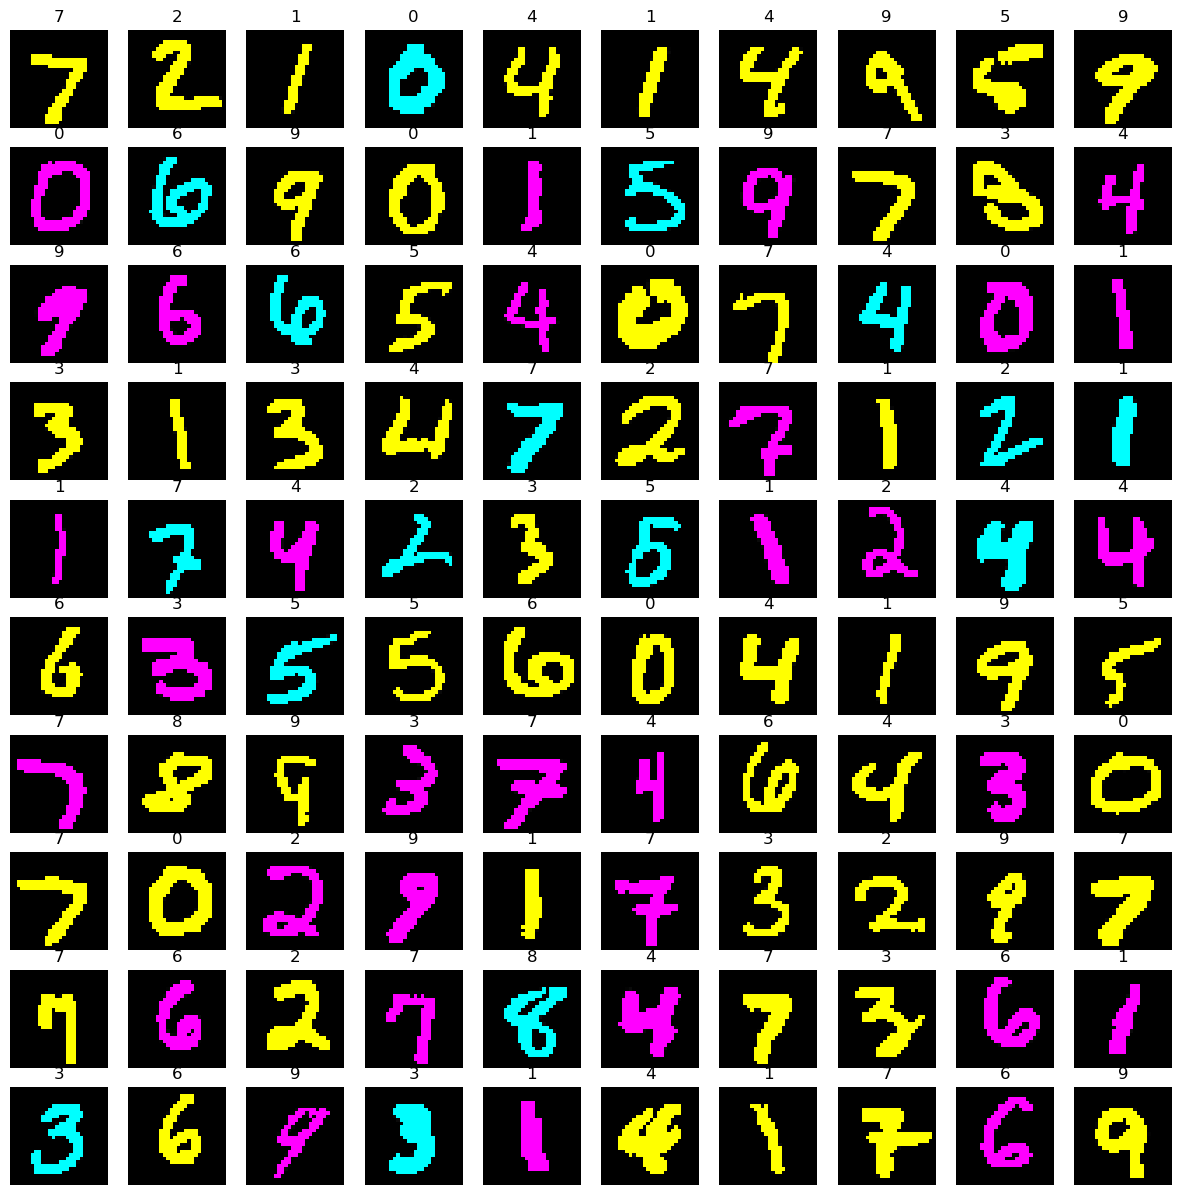

In [ ]:
fig,ax = plt.subplots(10,10,figsize=(15,15))
for i in range(10):
    for j in range(10):
        img, label = test[j+10*i]
        colored_img, label = color(img, label,train=False)
        ax[i][j].imshow(colored_img)
        ax[i][j].grid(False)
        ax[i][j].axis('off')
        ax[i][j].set_title(label)
plt.show()

In [ ]:
train = [color(im,l) for im,l in train]
test = [color(im,l,train=False) for im,l in test]

In [ ]:
train_labels = np.array([l for im,l in train])
train_images = np.array([im for im,l in train])
test_labels = np.array([l for im,l in test])
test_images = np.array([im for im,l in test]) 

In [ ]:
from models.model import ResNet50, ViTBase, CLIPModel
from models.utils import train_step, eval_step, DataLoaders
from models.transforms import transforms_resnet,transforms_clip_vit, transforms_vit
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10, CIFAR100, SVHN
from tqdm import tqdm
import pandas as pd
import warnings
from torch.utils.data import DataLoader, Dataset
warnings.filterwarnings("ignore")
BATCH_SIZE = 64
N_EPOCHS = 1

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.data = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
def train_and_eval(train_loader,test_loader,model,loss_fn,optimizer,device,modeltype):
    tr_metric = {"Accuracy":[],"Loss":[]}
    ts_metric = {"Accuracy":[],"Loss":[]}

    for epoch in tqdm(range(N_EPOCHS)):
        tr_loss, tr_acc = train_step(model,train_loader,loss_fn,optimizer,device,modeltype,data='svhn')
        ts_loss, ts_acc = eval_step(model,test_loader,loss_fn,device,modeltype,data="svhn")

        tr_metric["Accuracy"].append(tr_acc)
        tr_metric["Loss"].append(tr_loss)

        ts_metric["Accuracy"].append(ts_acc)
        ts_metric["Loss"].append(ts_loss)
    
    return tr_metric, ts_metric

## ResNet 50

In [ ]:
tr = CustomDataset(train_images,train_labels,transform=transforms_resnet)
ts = CustomDataset(test_images,test_labels,transform=transforms_resnet)

dl = DataLoaders(tr,ts,'resnet',128,True,'svhn')
train_loader, test_loader = dl.get_loaders()

resnet_model = ResNet50(n_classes=10)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters())
device = 'cuda' if torch.cuda.is_available() else 'cpu'


t,s = train_and_eval(train_loader,test_loader,resnet_model,loss_func,optimizer,device,'resnet50')

print("Final Train Accuracy:",t["Accuracy"][-1])
print("Final Test Accuracy:",s["Accuracy"][-1])
print("Final Train Loss:",t["Loss"][-1])
print("Final Test Loss:",s["Loss"][-1])

100%|██████████| 1/1 [01:30<00:00, 90.90s/it]

Final Train Accuracy: 0.74586666
Final Test Accuracy: 0.27089998
Final Train Loss: 1.041670167496972
Final Test Loss: 14.269006107426897


## VIT

In [ ]:
tr = CustomDataset(train_images,train_labels,transform=transforms_vit)
ts = CustomDataset(test_images,test_labels,transform=transforms_vit)
dl = DataLoaders(tr,ts,'vit',BATCH_SIZE,True,'svhn')
train_loader, test_loader = dl.get_loaders()

vit_model = ViTBase(n_classes=10)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.parameters())
device = 'cuda' if torch.cuda.is_available() else 'cpu'


t,s = train_and_eval(train_loader,test_loader,vit_model,loss_func,optimizer,device,'vit')

print("Final Train Accuracy:",t["Accuracy"][-1])
print("Final Test Accuracy:",s["Accuracy"][-1])
print("Final Train Loss:",t["Loss"][-1])
print("Final Test Loss:",s["Loss"][-1])

100%|██████████| 1/1 [03:23<00:00, 203.28s/it]

Final Train Accuracy: 0.8474167
Final Test Accuracy: 0.81689996
Final Train Loss: 0.5354294129716817
Final Test Loss: 0.51781879355953


## CLIP

In [ ]:
tr = CustomDataset(train_images,train_labels)
ts = CustomDataset(test_images,test_labels.astype(np.float32))
dl = DataLoaders(tr,ts,'clip',BATCH_SIZE,True,'svhn')
train_loader, test_loader = dl.get_loaders()

clip_model = CLIPModel(512)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(clip_model.parameters())
device = 'cuda' if torch.cuda.is_available() else 'cpu'


t,s = train_and_eval(train_loader,test_loader,clip_model,loss_func,optimizer,device,'clip')

print("Final Train Accuracy:",t["Accuracy"][-1])
print("Final Test Accuracy:",s["Accuracy"][-1])
print("Final Train Loss:",t["Loss"][-1])
print("Final Test Loss:",s["Loss"][-1])


100%|██████████| 1/1 [02:29<00:00, 149.23s/it]

Final Train Accuracy: 0.6331673
Final Test Accuracy: 0.81329995
Final Train Loss: 4.021138838758483
Final Test Loss: 1.913043029179239
